<div style="text-align: center">
    <h1 style="font-size: 42px;"><strong>EEG-based binary emotional arousal classification: </strong></h1>
</div>
<div style="text-align: center">
    <h3 h1 style="font-size: 30px;"><strong>Exploratory analysis and neural network model evaluation (DEAP Dataset)</strong></h3>
</div>

# **Table of contents**

# **1. Project overview**

# **2. Imports**

Let's first import all the necessary packages and libraries.


In [ ]:
import gdown
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from scipy.signal import spectrogram
from tensorflow.keras import models, layers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Dropout
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score
from xgboost import XGBClassifier

# **3. Loading and previewing EEG data**

## **3.1. Data exploration**

In [3]:
# file_id = '1IoR5kEBG86NHZcfYVGMCOdqV8S7MdKnu'
# gdown.download(f'https://drive.google.com/uc?id={file_id}', 'data_preprocessed_python/s01.dat', quiet=False)


We load EEG data for subject 1 from the DEAP dataset using Python’s pickle module. The `'rb'` flag opens the file in binary read mode, and `'latin1'` encoding ensures compatibility with the original format.

In [4]:
with open('data_preprocessed_python/s01.dat', 'rb') as file:    
    subject_data = pickle.load(file, encoding='latin1')

In [5]:
type(subject_data)

dict

In [6]:
print(subject_data.keys())

dict_keys(['labels', 'data'])


In [7]:
subject_eeg_data = subject_data['data']
subject_labels = subject_data['labels']

print(subject_eeg_data.shape)
print(subject_labels.shape)

(40, 40, 8064)
(40, 4)


The dataset is a Python dictionary containing two keys: `labels` and `data`.

`subject_data['data']` is an array of shape **40 x 40 x 8064** representing EEG and EOG data from 40 signal channels (32 EEG + 8 EOG/physiological). Each channel was sampled at 128 Hz over 60-second trials, resulting in 8064 time samples per trial. A total of 40 trials were recorded for this subject while watching 40 different videos.

`subject_data['labels']` is an array of shape **40 x 4**, where each row corresponds to a trial (one video) and contains subjective emotional ratings given by the participant. The four dimensions are:

- **valence** (*column 0*), 
- **arousal** (*column 1*), 
- **dominance** (*column 2*), and 
- **liking** (*column 3*). 

Emotional ratings were given on a **continuous scale from 1 to 9**, where higher values represent more positive valence, higher arousal, dominance, and liking.

*(See the samples of the data below)*

In [8]:
print(subject_eeg_data[0])

[[ 9.48231681e-01  1.65333533e+00  3.01372577e+00 ... -2.82648937e+00
  -4.47722969e+00 -3.67692812e+00]
 [ 1.24706590e-01  1.39008270e+00  1.83509881e+00 ... -2.98702069e+00
  -6.28780884e+00 -4.47429041e+00]
 [-2.21651099e+00  2.29201682e+00  2.74636923e+00 ... -2.63707760e+00
  -7.40651010e+00 -6.75590441e+00]
 ...
 [ 2.30779684e+02  6.96716323e+02  1.19512165e+03 ...  1.01080949e+03
   1.28312149e+03  1.51996480e+03]
 [-1.54180981e+03 -1.61798052e+03 -1.69268642e+03 ... -1.57842691e+04
  -1.57823160e+04 -1.57808512e+04]
 [ 6.39054310e-03  6.39054310e-03  6.39054310e-03 ... -9.76081241e-02
  -9.76081241e-02 -9.76081241e-02]]


In [9]:
df_labels = pd.DataFrame(
    subject_labels, 
    columns=['valence', 'arousal', 'dominance', 'liking']
)

df_labels.head(10)

,valence,arousal,dominance,liking
0,1.29,1.40,6.90,7.83
1,0.90,1.69,7.28,8.47
2,0.42,1.46,9.00,7.08
3,4.94,6.01,6.12,8.06
4,6.96,3.92,7.19,6.05
5,8.27,3.92,7.00,8.03
6,7.44,3.73,7.08,7.04
7,7.32,2.55,6.32,5.87
8,4.04,3.29,3.62,5.99
9,1.99,4.86,2.04,7.09


## **3.2. Data visualization**

First, we will look at the raw signal recorded during the first movie presentation. The plot below shows the record of the **first 5 seconds (640 samples)**.

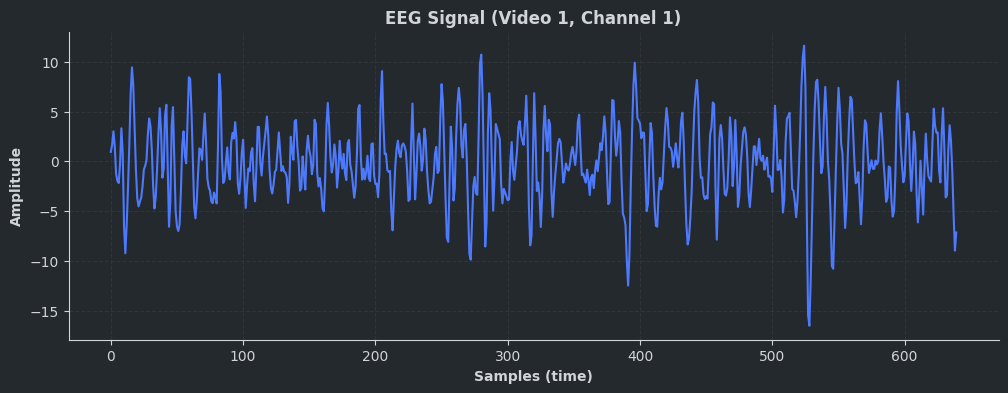

In [10]:
video_index = 0
channel_index = 0
sampling_frequency = 128

sample_signal = subject_eeg_data[video_index, channel_index, 0:sampling_frequency*5]

plt.figure(figsize=(12, 4))

ax = plt.gca()
ax.set_facecolor('#24292e')
plt.gcf().patch.set_facecolor('#24292e')

plt.plot(sample_signal, color='#4D79FD') 
plt.title(f'EEG Signal (Video {video_index + 1}, Channel {channel_index + 1})', color='#d1d5da', fontweight='bold')
plt.xlabel('Samples (time)', color='#d1d5da', fontweight='bold')
plt.ylabel('Amplitude', color='#d1d5da', fontweight='bold')

ax.tick_params(colors='#d1d5da')
ax.spines['bottom'].set_color('#d1d5da')
ax.spines['left'].set_color('#d1d5da')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.grid(True, linestyle='--', color='#313439')

plt.show()


The EEG signal shown above — already preprocessed in the source data to remove common artifacts such as eye blinks — reflects clean neural activity patterns suitable for further transformation into **frequency-domain features**. These features will later serve as input for a **convolutional neural network (CNN)** model in our emotion classification task.

To better understand the temporal dynamics of these frequency components, using `SciPy` library we compute a **spectrogram** of the signal recorded during the first movie presentation from the first channel. Spectrograms allow us to visualize **how the power of various frequency bands evolves over time**, which is particularly important in EEG-based emotion recognition — since distinct emotional states are often linked to specific oscillatory patterns in the brain (e.g., **Alpha (8-13 Hz)** suppression during heightened arousal, or increased **Theta (4-8 Hz)** activity during calmness or introspection).

*Note:*
*Due to the use of sliding windows with overlap in spectrogram computation* `(nperseg=128, noverlap=64)`*, the resulting time axis starts slightly after 0 seconds and ends before 5 seconds. This ensures that each time window contains a complete set of samples needed for the Fourier transform.*


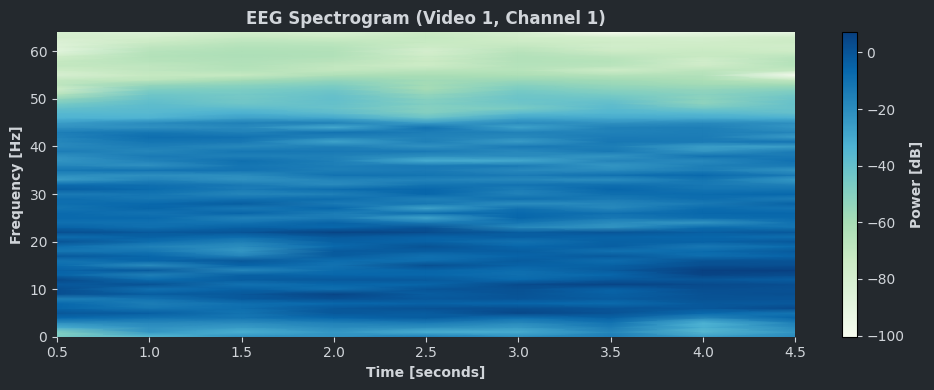

In [11]:
frequencies, times, spec_power = spectrogram(
    sample_signal, 
    fs=sampling_frequency, 
    nperseg=128, 
    noverlap=64
)

plt.figure(figsize=(10, 4))

ax = plt.gca()
ax.set_facecolor('#24292e')
plt.gcf().patch.set_facecolor('#24292e')

pcm = plt.pcolormesh(
    times, 
    frequencies, 
    10 * np.log10(spec_power), 
    shading='gouraud', 
    cmap='GnBu'
)

plt.title(f'EEG Spectrogram (Video {video_index + 1}, Channel {channel_index + 1})', color='#d1d5da', fontweight='bold')
plt.xlabel('Time [seconds]', color='#d1d5da', fontweight='bold')
plt.ylabel('Frequency [Hz]', color='#d1d5da', fontweight='bold')

ax.tick_params(colors='#d1d5da')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

plt.grid(False)

cbar = plt.colorbar(pcm)
cbar.ax.yaxis.set_tick_params(color='#d1d5da')
plt.setp(cbar.ax.yaxis.get_ticklabels(), color='#d1d5da')
cbar.set_label('Power [dB]', color='#d1d5da', fontweight='bold')

plt.tight_layout()
plt.show()


# **4. Neural network modeling**

## **4.1. Aggregating EEG data from all participants**

In [12]:
data_path = 'data_preprocessed_python'
all_eeg_data = []
all_labels = []

for i in range(1, 33):
    file_name = f's{i:02}.dat'
    file_path = os.path.join(data_path, file_name)

    with open(file_path, 'rb') as f:
        subject_data = pickle.load(f, encoding='latin1')
        all_eeg_data.append(subject_data['data'])
        all_labels.append(subject_data['labels'])

eeg_data_all = np.concatenate(all_eeg_data, axis=0)
labels_all = np.concatenate(all_labels, axis=0)

print(eeg_data_all.shape)
print(labels_all.shape)


(1280, 40, 8064)
(1280, 4)


## **4.2. Generating binary labels for classification**

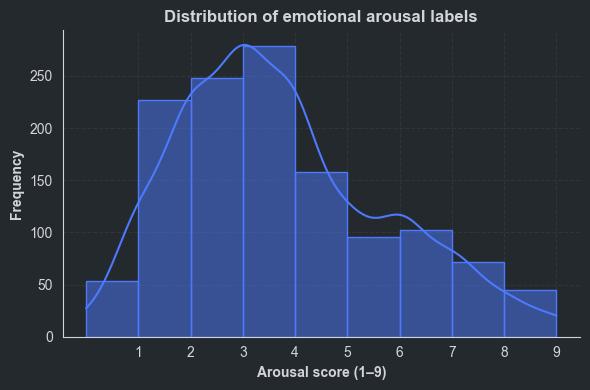

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

arousal_labels = labels_all[:, 1]

background_color = '#24292e'
line_color = '#4D79FD'
text_color = '#d1d5da'
grid_color = '#313439'

plt.figure(figsize=(6, 4))
ax = plt.gca()

ax.set_facecolor(background_color)
plt.gcf().patch.set_facecolor(background_color)

sns.histplot(arousal_labels, bins=9, kde=True, color=line_color, edgecolor=line_color, ax=ax)

ax.set_title('Distribution of emotional arousal labels', color=text_color, fontweight='bold')
ax.set_xlabel('Arousal score (1–9)', color=text_color, fontweight='bold')
ax.set_ylabel('Frequency', color=text_color, fontweight='bold')

ax.tick_params(colors=text_color)
ax.spines['bottom'].set_color(text_color)
ax.spines['left'].set_color(text_color)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.grid(True, linestyle='--', color=grid_color)

plt.xticks(range(1, 10), color=text_color)
plt.yticks(color=text_color)

plt.tight_layout()
plt.show()


In [384]:
arousal_labels = labels_all[:, 1]
median = np.median(arousal_labels)
print(f"Median score: {median}")

Median score: 3.315


In [ ]:
binary_arousal = (arousal_labels > median).astype(int)

print(np.unique(binary_arousal, return_counts=True))

(array([0, 1]), array([640, 640], dtype=int64))


## **4.3. Computing bandpower features (theta, alpha, beta, gamma) using Welch's method**

In [352]:
from scipy.signal import welch

def bandpower(signal, fs, band):
    f, Pxx = welch(signal, fs=fs)
    band_mask = (f >= band[0]) & (f <= band[1])
    return np.sum(Pxx[band_mask])

bands = {
    'theta': (4, 8),
    'alpha': (8, 13),
    'beta': (13, 30),
    'gamma': (30, 45)
}

X_features = []

for trial in eeg_data_all:
    features = []
    for ch in range(32):
        signal = trial[ch, :640]
        signal = (signal - np.mean(signal)) / (np.std(signal) + 1e-10)
        for band in bands.values():
            bp = bandpower(signal, fs=128, band=band)
            features.append(bp)
    X_features.append(features)

X = np.array(X_features)
y = binary_arousal

print("X shape:", X.shape)
print("y shape:", y.shape)


X shape: (1280, 128)
y shape: (1280,)


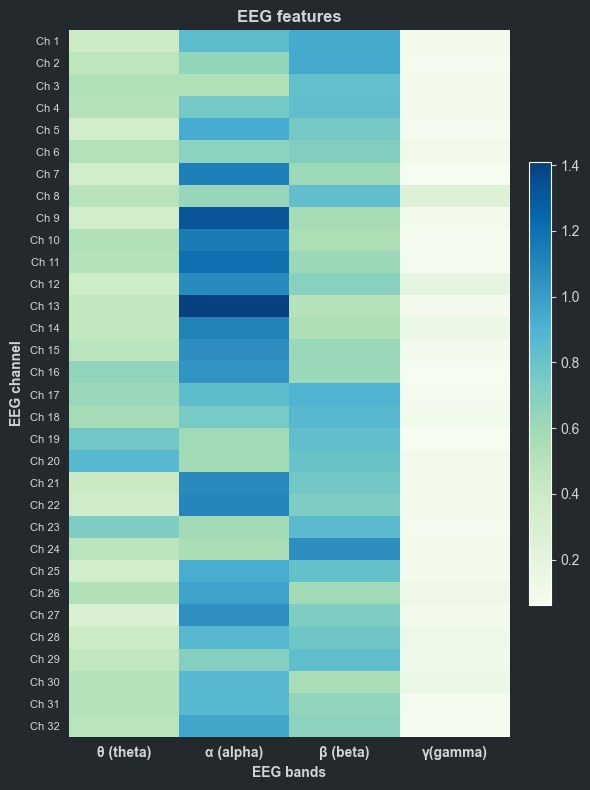

In [323]:
import matplotlib.pyplot as plt
import numpy as np

background_color = '#24292e'
text_color = '#d1d5da'
grid_color = '#313439'
cmap = 'GnBu'

example = X[0].reshape(32, 4)

fig, ax = plt.subplots(figsize=(6, 8))
fig.patch.set_facecolor(background_color)
ax.set_facecolor(background_color)

im = ax.imshow(example, aspect='auto', cmap=cmap)

ax.set_title("EEG features", color=text_color, fontweight='bold')
ax.set_xlabel("EEG bands", color=text_color, fontweight='bold')
ax.set_ylabel("EEG channel", color=text_color, fontweight='bold')
ax.set_xticks([0, 1, 2, 3])
ax.set_xticklabels(['θ (theta)', 'α (alpha)', 'β (beta)', 'γ(gamma)'], color=text_color, fontweight='bold')
ax.set_yticks(np.arange(32))
ax.set_yticklabels([f'Ch {i+1}' for i in range(32)], color=text_color, fontsize=8)

ax.tick_params(colors=text_color)
for spine in ax.spines.values():
    spine.set_visible(False)

cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
cbar.ax.yaxis.set_tick_params(color=text_color)
plt.setp(cbar.ax.yaxis.get_ticklabels(), color=text_color)

plt.tight_layout()
plt.show()


## **4.4. Dataset partitioning for model training and evaluation**

In [347]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y, 
    test_size=0.2, 
    random_state=42, 
    stratify=y
)

## **4.5. Neural network modeling**

In [368]:
model = Sequential([
    Input(shape=(128,)),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


## **4.6. Model training**

In [ ]:
history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=[EarlyStopping(patience=5, restore_best_weights=True)]
)


Epoch 1/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - accuracy: 0.4901 - loss: 0.7245 - val_accuracy: 0.4844 - val_loss: 0.6917
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4848 - loss: 0.7057 - val_accuracy: 0.5156 - val_loss: 0.6915
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5297 - loss: 0.7006 - val_accuracy: 0.5117 - val_loss: 0.6901
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5401 - loss: 0.6840 - val_accuracy: 0.5234 - val_loss: 0.6885
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5222 - loss: 0.6906 - val_accuracy: 0.5312 - val_loss: 0.6904
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5258 - loss: 0.6886 - val_accuracy: 0.5469 - val_loss: 0.6887
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5224 - loss: 0.6906 - val_accuracy: 0.5234 - val_loss: 0.6907
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5449 - loss: 0.6897 - val_accuracy: 0.5508 - val_loss

## **4.7. Model evaluation**

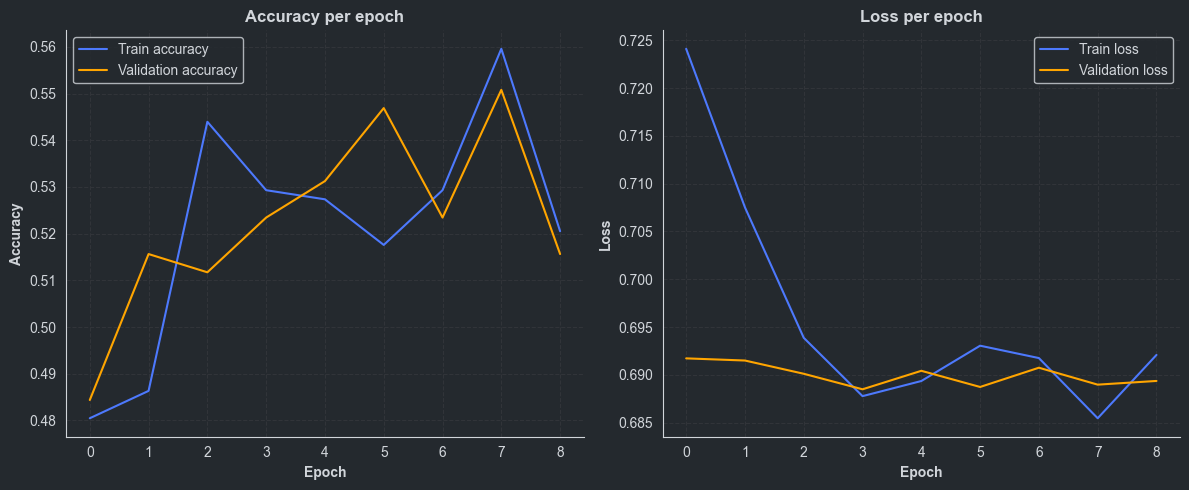

In [370]:
import matplotlib.pyplot as plt

background_color = '#24292e'
line_color = '#4D79FD'
text_color = '#d1d5da'
grid_color = '#313439'

plt.figure(figsize=(12, 5))

ax1 = plt.subplot(1, 2, 1)
ax1.set_facecolor(background_color)
plt.gcf().patch.set_facecolor(background_color)

ax1.plot(history.history['accuracy'], label='Train accuracy', color=line_color)
ax1.plot(history.history['val_accuracy'], label='Validation accuracy', color='orange')
ax1.set_title('Accuracy per epoch', color=text_color, fontweight='bold')
ax1.set_xlabel('Epoch', color=text_color, fontweight='bold')
ax1.set_ylabel('Accuracy', color=text_color, fontweight='bold')
ax1.legend(facecolor=background_color, edgecolor=text_color, labelcolor=text_color)
ax1.tick_params(colors=text_color)
ax1.spines['bottom'].set_color(text_color)
ax1.spines['left'].set_color(text_color)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.grid(True, linestyle='--', color=grid_color)

ax2 = plt.subplot(1, 2, 2)
ax2.set_facecolor(background_color)

ax2.plot(history.history['loss'], label='Train loss', color=line_color)
ax2.plot(history.history['val_loss'], label='Validation loss', color='orange')
ax2.set_title('Loss per epoch', color=text_color, fontweight='bold')
ax2.set_xlabel('Epoch', color=text_color, fontweight='bold')
ax2.set_ylabel('Loss', color=text_color, fontweight='bold')
ax2.legend(facecolor=background_color, edgecolor=text_color, labelcolor=text_color)
ax2.tick_params(colors=text_color)
ax2.spines['bottom'].set_color(text_color)
ax2.spines['left'].set_color(text_color)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.grid(True, linestyle='--', color=grid_color)

plt.tight_layout()
plt.show()


In [372]:
y_pred_probs = model.predict(X_test)
y_pred = (y_pred_probs > 0.5).astype(int)

print(f'Accuracy: {accuracy_score(y_test, y_pred):.2f}')
print(f'ROC AUC: {roc_auc_score(y_test, y_pred_probs):.2f}')


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
Accuracy: 0.52
ROC AUC: 0.60


# **4. Alternative machine learning models evaluation**

## **4.1. Logistic regression**

In [373]:
lr = LogisticRegression(max_iter=1000, random_state=42)
lr.fit(X_train_scaled, y_train)

y_pred = lr.predict(X_test_scaled)
y_prob = lr.predict_proba(X_test_scaled)[:, 1]

print("Logistic Regression:")
print(classification_report(y_test, y_pred))
print(f'ROC AUC: {roc_auc_score(y_test, y_pred_probs):.2f}')


Logistic Regression:
              precision    recall  f1-score   support

           0       0.54      0.66      0.60       128
           1       0.57      0.45      0.50       128

    accuracy                           0.55       256
   macro avg       0.56      0.55      0.55       256
weighted avg       0.56      0.55      0.55       256

ROC AUC: 0.60


## **4.2. Random forest**

In [374]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)
y_prob = rf.predict_proba(X_test)[:, 1]

print("Random forest:")
print(classification_report(y_test, y_pred))
print(f'ROC AUC: {roc_auc_score(y_test, y_pred_probs):.2f}')


Random forest:
              precision    recall  f1-score   support

           0       0.58      0.71      0.64       128
           1       0.63      0.49      0.55       128

    accuracy                           0.60       256
   macro avg       0.61      0.60      0.60       256
weighted avg       0.61      0.60      0.60       256

ROC AUC: 0.60


## **4.3. Support vector machine**

In [375]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

svm = SVC(kernel='rbf', probability=True, random_state=42)
svm.fit(X_train_scaled, y_train)

y_pred = svm.predict(X_test_scaled)
y_prob = svm.predict_proba(X_test_scaled)[:, 1]

print("SVM:")
print(classification_report(y_test, y_pred))
print(f'ROC AUC: {roc_auc_score(y_test, y_pred_probs):.2f}')


SVM:
              precision    recall  f1-score   support

           0       0.56      0.73      0.64       128
           1       0.62      0.43      0.51       128

    accuracy                           0.58       256
   macro avg       0.59      0.58      0.57       256
weighted avg       0.59      0.58      0.57       256

ROC AUC: 0.60


## **4.4. XGBoost**

In [376]:
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb.fit(X_train, y_train)

y_pred = xgb.predict(X_test)
y_prob = xgb.predict_proba(X_test)[:, 1]

print("XGBoost:")
print(classification_report(y_test, y_pred))
print(f'ROC AUC: {roc_auc_score(y_test, y_pred_probs):.2f}')


c:\Users\Huawei\anaconda\Lib\site-packages\xgboost\training.py:183: UserWarning: [21:41:58] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost:
              precision    recall  f1-score   support

           0       0.57      0.67      0.62       128
           1       0.60      0.50      0.55       128

    accuracy                           0.59       256
   macro avg       0.59      0.59      0.58       256
weighted avg       0.59      0.59      0.58       256

ROC AUC: 0.60


# **5. Results summary**

In [381]:
results = pd.DataFrame({
    'Model': ['Neural network', 'Logistic regression', 'Random forest', 'SVM', 'XGBoost'],
    'Accuracy': [0.52, 0.55, 0.60, 0.58, 0.59],
    'ROC AUC': [0.60, 0.60, 0.60, 0.60, 0.60]
})

results

,Model,Accuracy,ROC AUC
0,Neural network,0.52,0.6
1,Logistic regression,0.55,0.6
2,Random forest,0.60,0.6
3,SVM,0.58,0.6
4,XGBoost,0.59,0.6
